## Imports

In [1]:
import dostools
import importlib
import numpy as np
import pickle
import torch
import sys
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import matplotlib
import time
torch.set_default_dtype(torch.float64) 
# %matplotlib notebook
# matplotlib.rcParams['figure.figsize'] = (10, 10)

In [2]:
import dostools.datasets.data as data
import dostools.utils.utils as utils
importlib.reload(data)

n_structures = 1039
np.random.seed(0)
n_train = int(0.8 * n_structures)
train_index = np.arange(n_structures)
np.random.shuffle(train_index)
test_index = train_index[n_train:]
train_index = train_index[:n_train]

with torch.no_grad():
    structures = data.load_structures(":")
    n_structures = len(structures) #total number of structures
    for structure in structures:#implement periodicity
        structure.wrap(eps = 1e-12) 
    n_atoms = np.zeros(n_structures, dtype = int) #stores number of atoms in each structures
    for i in range(n_structures):
        n_atoms[i] = len(structures[i])

    #eigenergies, emin, emax = dostools.src.datasets.data.load_eigenenergies(unpack = True, n_structures = len(structures))
    xdos = torch.tensor(data.load_xdos())
    ldos = torch.tensor(data.load_ldos())
    ldos *= 2

    print ("ldos shape is {}".format(ldos.shape))
    mean_dos_per_atom = ldos[train_index].mean(axis = 0) #only calculated for train set to prevent data leakage
    print ("mean dos shape is {}".format(mean_dos_per_atom.shape))
    
    
    y_pw = ldos - mean_dos_per_atom
    y_lcdf = torch.cumsum(y_pw, dim = 1)
    _, pc_vectors = utils.build_pc(ldos[train_index], mean_dos_per_atom[None,:], n_pc = 10)
    y_pc = utils.build_coeffs(ldos - mean_dos_per_atom[None,:], pc_vectors)
    Silicon = data.load_features()
    kMM = data.load_kMM()
    structure_eigvals_t, structure_coefficients_t, reconstructed_ldos_t = data.load_structure_gaussians()


ldos shape is torch.Size([1039, 778])
mean dos shape is torch.Size([778])
Variance covered with 10 PCs is = 0.9871211778950163


In [3]:
sigma = 0.3
dx = 0.05
eigen_energies, emin, emax = data.load_eigenenergies(unpack = True, n_structures = 1039)
full_eigen_energies = [torch.tensor(i.flatten()) for i in eigen_energies]
eigenenergy_length = [len(i) for i in full_eigen_energies]
eigenenergy_length_t = torch.tensor(eigenenergy_length)
n_atoms_t = torch.tensor(n_atoms)
normalization_eiglength = [len(i) for i in eigen_energies]
normalization_eiglength_t = torch.tensor(normalization_eiglength)
normalization = 1/torch.sqrt(2*torch.tensor(np.pi)*sigma**2)/n_atoms_t/normalization_eiglength_t
normalization_quartic = 1/n_atoms/normalization_eiglength_t

This file contains the eigenenergies and their corresponding kpoints of the training Silicon structures generated using DFT PBE as implemented in FHI-AIMS version 171221_1 with the ``tight'' settings


## Fourier Transform Preprocessing

In [4]:
def fourier_transform_dos(energies, emin, emax, num_frequencies, smearing):
    """
    For a provided array of energies, compute the Fourier coefficients
    of the density of states.

    Parameters
    ----------
    energies : torch.tensor
        Tensor containing all energy levels
    emin : float
        Minimum energy for the interval
    emax : float
        Maximum energy for the interval
    num_frequencies : int
        Number of Fourier space frequencies to use
    smearing: float
        Width of Gaussian smearing applied to each energy level

    Returns
    -------
    coeffs: torch.tensor (dtype=complex)
        Tensor containing Fourier coefficients
    """

    # Initialization
#     coeffs = []
    length_interval = emax - emin
    
    # Make sure that all energies lie in the interval
    assert min(energies) > emin
    assert max(energies) < emax
    
    # For all frequencies, compute the Fourier coefficients by
    # accumulating contributions from all the energy levels
    k = torch.arange(num_frequencies)
    k_scaled = k * 2*np.pi / length_interval
    coeffs = torch.sum(torch.exp(-1j*k_scaled.view(-1,1)*energies), dim = 1)
    coeffs *= torch.exp(-0.5*smearing**2*k_scaled**2)
    coeffs *= np.sqrt(2*np.pi*smearing**2) 
#     for k in range(num_frequencies):
#         # Rescale the frequency to make the "plane waves" periodic with
#         # respect to the energy interval (rather than having a period of 2pi)
#         k_scaled = torch.tensor(k * 2*np.pi / length_interval)
        
#         # Add up contributions from all energy levels
#         coeffs_k = torch.sum(torch.exp(-1j*k_scaled*energies))
        
#         # Multiply by factor only dependent on k
#         coeffs_k *= torch.exp(-0.5*smearing**2*k_scaled**2)
        
#         coeffs.append(coeffs_k)
    
#     # Multiply by global factor
#     coeffs = torch.hstack(coeffs)
#     coeffs *= np.sqrt(2*np.pi*smearing**2) 
    
    return coeffs

def evaluate_dos_from_fourier(coeffs, emin, emax, num_eval=50):
    """
    Evaluate the DOS from the Fourier coefficients on a specified interval.
    

    Parameters
    ----------
    coeffs: torch.tensor
        Tensor containing all Fourier coefficients
    emin : float
        Minimum energy for the interval
    emax : float
        Maximum energy for the interval
    num_eval : int
        Number of energy points on which to evaluate the DOS.
        To be more precise, the energies are evaluated on
        np.linspace(emin, emax, num_eval)

    Returns
    -------
    dos:
        DOS evaluated at specified energy interval (see above).

    """
    # Initialize arrays and variables
#     energies = torch.linspace(emin, emax, num_eval)
#     length_interval = emax - emin
#     dos = torch.zeros((num_eval,), dtype=torch.cdouble)
    
    
    
    
#     # Compute the DOS by accumulating contributions from all frequencies
#     for k, coeff in enumerate(coeffs):
#         # Rescale frequency k to match periodicity of energy interval
#         k_scaled = torch.tensor(k * 2*np.pi / length_interval)
        
#         # Accumulate contribution from frequency k to DOS
#         dos += coeff * torch.exp(1j*k_scaled*energies)
        
#     # Convert complex Fourier transform into real form
#     dos_real = 2 * torch.real(dos) - torch.real(coeffs[0])
    
#     # Global prefactor of inverse Fourier transform
#     dos_real /= length_interval
    
#     return dos_real

    energies = torch.linspace(emin,emax, num_eval)
    length_interval = emax - emin
    dos = torch.zeros((coeffs.shape[0], num_eval), dtype = torch.cdouble)
    
    k = torch.arange(coeffs.shape[1])
    k_scaled = k * 2*np.pi/length_interval
    dos = coeffs @ (torch.exp(1j * k_scaled.view(-1,1)*energies))
    dos_real = 2 * torch.real(dos) - torch.real(coeffs[:,:1])
    dos_real /= length_interval
    
    return dos_real
    

def shift_coeffs(coeffs, emin, emax, delta):
    """
    Recompute Fourier coefficients of shifted DOS function.

    Parameters
    ----------
    coeffs: torch.tensor
        Tensor containing all Fourier coefficients
    emin : float
        Minimum energy for the interval
    emax : float
        Maximum energy for the interval
    delta : torch.tensor
        Amount by which the DOS is shifted

    Returns
    -------
    coeffs_shifted : torch.tensor (dtype=cdouble)
        Fourier coefficients of shifted DOS

    """
    # Initialization
#     coeffs_shifted = []
#     coeffs_shifted = torch.zeros_like(coeffs)
#     length_interval = emax - emin
    
#     # Compute the DOS by accumulating contributions from all frequencies
#     for k, coeff in enumerate(coeffs):
#         # Rescale frequency k to match periodicity of energy interval
#         k_scaled = torch.tensor(k * 2*np.pi / length_interval)
        
#         coeffs_shifted_k = coeffs[k] * torch.exp(-1j*k_scaled*delta)
#         coeffs_shifted.append(coeffs_shifted_k)

    length_interval = emax - emin
    k = torch.arange(coeffs.shape[1])
    k_scaled = k * 2*np.pi/ length_interval
    coeffs_shifted = coeffs * torch.exp(-1j * k_scaled*delta.view(-1,1))
    
    return coeffs_shifted

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [03:38<00:00,  4.75it/s]

Computed 50 complex Fourier coeffs.
  --> corresponds to 99 real coeffs.

Duration = 218.7783s


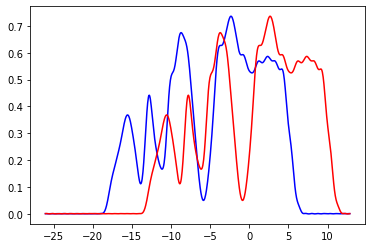

In [5]:
energies = full_eigen_energies
emin = -24.553719539983 - 1.5
emax = 11.346414696331 + 1.5
num_frequencies = 50
smearing = 0.3

# Compute Fourier coefficients
t0 = time.time()
coeffs = []
for i in tqdm(full_eigen_energies):
    coeffs_i = fourier_transform_dos(i, emin, emax, num_frequencies, smearing)
    coeffs.append(coeffs_i)

coeffs = torch.vstack(coeffs)
coeffs = ((coeffs.T * normalization).T) * 2
# Print required time
dt = time.time()-t0
print(f'Computed {num_frequencies} complex Fourier coeffs.')
print(f'  --> corresponds to {2*num_frequencies-1} real coeffs.')
print(f'\nDuration = {dt:6.4f}s')
# print(f'Estimate for 5000 frames = {5000*dt:5.1f}s = {500/6*dt:3.2f}min')

# Evaluate DOS and plot

f_ldos = evaluate_dos_from_fourier(coeffs, emin, emax, num_eval=778)
ene_plot = np.linspace(emin, emax, len(f_ldos[0]))
plt.plot(ene_plot, f_ldos[0], c= 'b')
# plt.plot(xdos, ldos[0])

# Plot shifted version as well
coeffs_shifted = shift_coeffs(coeffs[:1], emin, emax, delta=torch.tensor([5]))
dos_shifted = evaluate_dos_from_fourier(coeffs_shifted, emin, emax, num_eval=778)
plt.plot(ene_plot, dos_shifted[0], c= 'r')

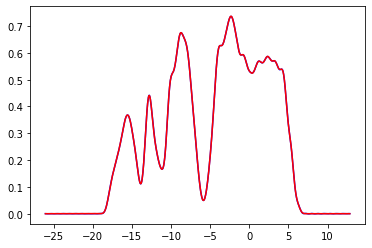

In [6]:
plt.plot(ene_plot, f_ldos[0], c= 'b')
plt.plot(xdos, ldos[0], c= 'r')

## Biased Train-test split

In [7]:
#Selected Amorphous structures

amorph_train = np.arange(939,1039,1)
np.random.seed(0)
np.random.shuffle(amorph_train)

amorph_test = amorph_train[:80]
amorph_train = amorph_train[80:]

n_structures2 = 939
np.random.seed(0)
n_train = int(0.8 * 1039)-20
remaining_train_index = np.arange(n_structures2)
np.random.shuffle(remaining_train_index)

remaining_test_index = remaining_train_index[n_train:]
remaining_train_index = remaining_train_index[:n_train]

biased_train_index = np.concatenate([remaining_train_index, amorph_train])
biased_test_index = np.concatenate([remaining_test_index, amorph_test])

In [8]:
# Fermi level
import ase

T_0 = 200
beta_0 = 1 / (ase.units.kB * T_0) # inverse temperature
efermi = torch.zeros(n_structures)
for i in range(n_structures):
    efermi[i] = torch.tensor(utils.getmu(ldos[i], beta_0, xdos, n=4))

In [9]:
cutoff = torch.max(efermi) + 3
cutoff_index = torch.searchsorted(xdos, cutoff)

## Test Loss function

In [10]:
def MSE_shift_fourier(x_pred, target, n_epochs):
    shifts = torch.nn.parameter.Parameter(torch.zeros(target.shape[0]))
    opt_LBFGS = torch.optim.LBFGS([shifts], lr = 1, line_search_fn = 'strong_wolfe', tolerance_grad = 1e-15, tolerance_change = 1e-15)#, weight_decay = 0)
    opt_adam = torch.optim.Adam([shifts], lr = 1e-2, weight_decay = 0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_adam, factor = 0.1, patience = 20, threshold = 1e-7, min_lr = 1e-7)
   
    for i in range(n_epochs):
        def closure():
            opt_LBFGS.zero_grad()
            shifted_preds = shift_coeffs(x_pred, emin, emax, shifts)
#             shifted_ldos = evaluate_dos_from_fourier(shifted_preds, emin, emax, num_eval=778)
            loss_i = torch.mean(abs(shifted_preds- target)**2) 
#             loss_i = loss.t_get_mse(shifted_ldos[:,cutoff_index], target[:,cutoff_index])
            loss_i.backward(gradient = torch.tensor(1), inputs = shifts )
            return (loss_i)

        mse = opt_LBFGS.step(closure)
        
    return mse, shifts

In [11]:
true_alignments = (torch.rand(1039)-0.5) * 8 #true_alignments.clone()
shifted_target = shift_coeffs(coeffs, emin ,emax, true_alignments)
error, align = MSE_shift_fourier(shifted_target, coeffs, 5)
print (torch.where(abs(true_alignments + align)>1e-3))

(tensor([105, 112]),)


## Generate Features

In [12]:
import rascaline
from skcosmo.feature_selection import FPS
import scipy

HYPER_PARAMETERS = {
    "cutoff": 4.0,#6.0,#4.0,
    "max_radial": 8,#12,#8,
    "max_angular": 6,#9,#6,
    "atomic_gaussian_width": 0.45,
    "center_atom_weight": 1.0,
    "radial_basis":{
        "Gto":{}
    },
    "cutoff_function":{
        "Step":{}, #maybe 
    },
    "radial_scaling":{
        "Willatt2018":{
        'exponent': 5,
        'rate' : 1,
        'scale' : 3.,
        },
    },
}

calculator = rascaline.SoapPowerSpectrum(**HYPER_PARAMETERS)
descriptors = calculator.compute(structures)
descriptors.keys_to_samples("species_center")
descriptors.keys_to_properties(["species_neighbor_1", "species_neighbor_2"])



n_refs = 200
n_atoms = descriptors.block(0).values.shape[0]
n_structures = np.unique(descriptors.block(0).samples["structure"])
feature = torch.zeros(len(n_structures), n_refs)
atom_descriptors = torch.tensor(descriptors.block(0).values)
atom_descriptors = torch.nn.functional.normalize(atom_descriptors, dim = 1)
selector = FPS(n_to_select = n_refs,
           progress_bar = True,
           score_threshold = 1e-12,
           full = False,
           initialize = 0
          )
selector.fit(atom_descriptors.T)
references = selector.transform(atom_descriptors.T).T
atomkernel_descriptors = torch.pow(atom_descriptors @ references.T, 2)
for structure_i in n_structures:
    a_i = descriptors.block(0).samples["structure"] == structure_i
    feature[structure_i, :] = torch.sum(atomkernel_descriptors[a_i, :], axis = 0)/np.sum(a_i)

kMM = references @ references.T
rtkMM = scipy.linalg.sqrtm(kMM)

  0%|          | 0/199 [00:00<?, ?it/s]

## Analytical training Unbiased


In [33]:
from dostools.loss import loss
#normal dataset

batch_size = 32
sigma = 0.3
n_epochs = 100000
patience = 20

index = train_index
t_index = test_index

Sampler = torch.utils.data.RandomSampler(index, replacement = False)
Batcher = torch.utils.data.BatchSampler(Sampler, batch_size, False)

Features = torch.hstack([feature[index].double(), torch.ones(len(index)).view(-1,1)]).type(dtype = torch.complex128)
t_Features = torch.hstack([feature[t_index].double(), torch.ones(len(t_index)).view(-1,1)]).type(dtype = torch.complex128)
# Features = torch.hstack([Silicon.Features['structure_avedescriptors'][index].double(), torch.ones(len(index)).view(-1,1)])
# t_Features = torch.hstack([Silicon.Features['structure_avedescriptors'][t_index].double(), torch.ones(len(t_index)).view(-1,1)])
# alignment = torch.nn.parameter.Parameter(torch.zeros(len(index)))
#alignment = torch.nn.parameter.Parameter(torch.rand(len(index))-0.5)

opt = torch.optim.Adam([alignment], lr = 1e-3, weight_decay = 0)
# opt_LBFGS = torch.optim.LBFGS([alignment], lr = 1e-3, line_search_fn = 'strong_wolfe', tolerance_grad = 1e-15, tolerance_change = 1e-15)#, weight_decay = 0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = 20, threshold = 1e-5, min_lr = 1e-8)

xdos_i = xdos.clone()
# cutoff = torch.max(efermi) + 3
# cutoff_index = torch.searchsorted(xdos, cutoff)

train_ldos = coeffs[index,:].clone()#n_ldos2[index,:cutoff_index].clone()

best_mse = torch.tensor(100)
best_state = alignment.clone()

n_col = Features.shape[1]
regularization = 1

reg = torch.hstack([torch.real(torch.tensor(regularization * rtkMM)), torch.zeros(rtkMM.shape[0]).view(-1,1)])
reg = torch.vstack([reg, torch.zeros(n_col)])


reg_features = torch.vstack([Features, reg])
reg_target = torch.vstack([train_ldos, torch.zeros(n_col,train_ldos.shape[1])])
reference_weights = torch.linalg.lstsq(reg_features, reg_target, driver = "gelsd", rcond = 1e-10).solution
reference_pred = Features @ reference_weights
reference_t_pred = t_Features @ reference_weights



train_loss = torch.mean(abs(reference_pred- train_ldos)**2) 
test_loss = torch.mean(abs(reference_t_pred- coeffs[test_index])**2) 
current_rmse = torch.tensor(100)
pred_loss = torch.tensor(100)
prev_loss = torch.tensor(100)
trigger = 0
print ("Reference training loss: {:.6}".format(train_loss))
print ("Reference test loss : {:.6}".format(test_loss))

pbar = tqdm(range(n_epochs))
for epoch in pbar:
    pbar.set_description(f"Epoch: {epoch}")
    pbar.set_postfix(pred_loss = pred_loss.item(), lowest_mse = best_mse.item(), trigger = trigger)
    for i_batch in Batcher:
        def closure():
            opt.zero_grad()
            reg_features_i = torch.vstack([Features[i_batch], reg])
            shifted_target = shift_coeffs(train_ldos[i_batch], emin, emax, alignment[i_batch])            
            shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])          
            train_weights = torch.linalg.lstsq(reg_features_i, shifted_reg_target, rcond = 1e-10, driver = "gelsd").solution
            shifted_train_preds = Features[i_batch] @ train_weights
            loss_i = torch.mean(abs(shifted_train_preds - shifted_target)**2) 
            loss_i.backward(inputs = alignment)
            return loss_i
        opt.step(closure)
        train_ldos = train_ldos.detach()
        
    with torch.no_grad():
        shifted_target = shift_coeffs(train_ldos, emin, emax, alignment)
        shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])          
        train_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, rcond = 1e-10, driver = "gelsd").solution
        pred_i = Features @ train_weights
        
        
        i_loss = torch.mean(abs(pred_i - shifted_target)**2) 
       
        pred_loss = i_loss
        if i_loss < prev_loss * (1 + 1e-3): 
            trigger = 0
        else:
            trigger +=1 
            if trigger >= patience:
                alignment = torch.nn.parameter.Parameter(best_state)
                opt = torch.optim.Adam([alignment], lr = opt.param_groups[0]['lr'], weight_decay = 0)
                counter = 0

        if i_loss < best_mse:
            best_mse = i_loss
            best_state = alignment.clone()

        prev_loss = i_loss

        scheduler.step(i_loss)
        if Batcher.batch_size > 1024:
            break
            
        if opt.param_groups[0]['lr'] < 1e-3:
            Batcher.batch_size *= 2 
            opt.param_groups[0]['lr'] = 1e-3
            print ("The batch_size is now:", Batcher.batch_size)

            
            


shifted_target = shift_coeffs(train_ldos, emin, emax, best_state)    
shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])   


shifted_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, driver = "gelsd").solution
shifted_preds = Features @ shifted_weights
shifted_t_preds = t_Features @ shifted_weights


shifted_train_loss = torch.mean(abs(shifted_preds - shifted_target)**2)#loss.t_get_rmse(shifted_preds, shifted_target, xdos, perc = True)
# shifted_test_loss = loss.t_get_rmse(shifted_t_preds, shifted_ldos, xdos, perc = True) Need the one with the new loss function

print ("Final training loss: {:.6}".format(shifted_train_loss))


Reference training loss: 0.0015957
Reference test loss : 0.00222239


Epoch: 8:   0%|                                                                                                            | 8/100000 [00:09<34:18:21,  1.24s/it, lowest_mse=0.00159, pred_loss=0.00159, trigger=0]


KeyboardInterrupt: 

In [ ]:
alignment

## Analytical training function

In [15]:
from dostools.loss import loss

emin = -24.553719539983 - 1.5
emax = 11.346414696331 + 1.5

def find_optimal_alignment_fourier(init_alignment, feature, target, rtkMM, train_index, test_index, n_epochs):
    batch_size = 32
    sigma = 0.3
    n_epochs = n_epochs
    patience = 20

    index = train_index
    t_index = test_index

    Sampler = torch.utils.data.RandomSampler(index, replacement = False)
    Batcher = torch.utils.data.BatchSampler(Sampler, batch_size, False)

    Features = torch.hstack([feature[index].double(), torch.ones(len(index)).view(-1,1)]).type(dtype = torch.complex128)
    t_Features = torch.hstack([feature[t_index].double(), torch.ones(len(t_index)).view(-1,1)]).type(dtype = torch.complex128)
    alignment = init_alignment.clone()

    opt = torch.optim.Adam([alignment], lr = 1e-3, weight_decay = 0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = 20, threshold = 1e-5, min_lr = 1e-8)
    train_ldos = target[index,:].clone()#n_ldos2[index,:cutoff_index].clone()

    best_mse = torch.tensor(100)
    best_state = alignment.clone()

    n_col = Features.shape[1]
    regularization = 1

    reg = torch.hstack([torch.real(torch.tensor(regularization * rtkMM)), torch.zeros(rtkMM.shape[0]).view(-1,1)])
    reg = torch.vstack([reg, torch.zeros(n_col)])


    reg_features = torch.vstack([Features, reg])
    reg_target = torch.vstack([train_ldos, torch.zeros(n_col,train_ldos.shape[1])])
    reference_weights = torch.linalg.lstsq(reg_features, reg_target, driver = "gelsd", rcond = 1e-10).solution
    reference_pred = Features @ reference_weights
    reference_t_pred = t_Features @ reference_weights



    train_loss = torch.mean(abs(reference_pred- train_ldos)**2) 
    test_loss = torch.mean(abs(reference_t_pred- target[test_index])**2) 
    current_rmse = torch.tensor(100)
    pred_loss = torch.tensor(100)
    prev_loss = torch.tensor(100)
    trigger = 0
    print ("Reference training loss: {:.6}".format(train_loss))
    print ("Reference test loss : {:.6}".format(test_loss))

    pbar = tqdm(range(n_epochs))
    for epoch in pbar:
        pbar.set_description(f"Epoch: {epoch}")
        pbar.set_postfix(pred_loss = pred_loss.item(), lowest_mse = best_mse.item(), trigger = trigger)
        for i_batch in Batcher:
            def closure():
                opt.zero_grad()
                reg_features_i = torch.vstack([Features[i_batch], reg])
                shifted_target = shift_coeffs(train_ldos[i_batch], emin, emax, alignment[i_batch])            
                shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])          
                train_weights = torch.linalg.lstsq(reg_features_i, shifted_reg_target, rcond = 1e-10, driver = "gelsd").solution
                shifted_train_preds = Features[i_batch] @ train_weights
                loss_i = torch.mean(abs(shifted_train_preds - shifted_target)**2) 
                loss_i.backward(inputs = alignment)
                return loss_i
            opt.step(closure)
            train_ldos = train_ldos.detach()

        with torch.no_grad():
            shifted_target = shift_coeffs(train_ldos, emin, emax, alignment)
            shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])          
            train_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, rcond = 1e-10, driver = "gelsd").solution
            pred_i = Features @ train_weights
            i_loss = torch.mean(abs(pred_i - shifted_target)**2) 

            pred_loss = i_loss
            if i_loss < prev_loss * (1 + 1e-3): 
                trigger = 0
            else:
                trigger +=1 
                if trigger >= patience:
                    alignment = torch.nn.parameter.Parameter(best_state)
                    opt = torch.optim.Adam([alignment], lr = opt.param_groups[0]['lr'], weight_decay = 0)
                    counter = 0

            if i_loss < best_mse:
                best_mse = i_loss
                best_state = alignment.clone()

            prev_loss = i_loss

            scheduler.step(i_loss)
            if Batcher.batch_size > 1024:
                break

            if opt.param_groups[0]['lr'] < 1e-3:
                Batcher.batch_size *= 2 
                opt.param_groups[0]['lr'] = 1e-3
                print ("The batch_size is now:", Batcher.batch_size)

    shifted_target = shift_coeffs(train_ldos, emin, emax, best_state)    
    shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])   


    shifted_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, driver = "gelsd").solution
    shifted_preds = Features @ shifted_weights
    shifted_t_preds = t_Features @ shifted_weights


    shifted_train_loss = torch.mean(abs(shifted_preds - shifted_target)**2)#loss.t_get_rmse(shifted_preds, shifted_target, xdos, perc = True)
    # shifted_test_loss = loss.t_get_rmse(shifted_t_preds, shifted_ldos, xdos, perc = True) Need the one with the new loss function

    print ("Final training loss: {:.6}".format(shifted_train_loss))
    
    return alignment


In [16]:
index = train_index
t_index = test_index
# init = (torch.rand(len(index))-0.5) * 0.2
init = torch.zeros(len(index)) + 2
opt_align = find_optimal_alignment_fourier(init, feature, coeffs, rtkMM, train_index, test_index, 200000)

Reference training loss: 0.0015957
Reference test loss : 0.00222239


Epoch: 0:   0%|                                                                                                                               | 0/200000 [00:00<?, ?it/s, lowest_mse=100, pred_loss=100, trigger=0]


RuntimeError: torch.linalg.lstsq: input.size(-2) should match other.size(-2)

In [200]:
opt_align

Parameter containing:
tensor([1.7371, 1.9157, 1.5303, 2.2095, 2.0222, 2.0606, 2.0495, 1.7668, 2.3179,
        2.3628, 2.2796, 2.0343, 1.9164, 2.2186, 1.8162, 2.2409, 1.8968, 1.9192,
        1.9806, 1.9331, 2.0873, 2.1195, 1.9350, 2.1696, 1.9427, 1.9221, 1.8112,
        1.8066, 2.0281, 2.2895, 2.0228, 1.8491, 2.1076, 1.8967, 1.8929, 1.9000,
        1.9361, 1.7421, 2.2460, 1.9817, 2.3208, 2.2714, 1.8864, 1.8913, 2.1076,
        2.2187, 1.9073, 2.0621, 2.0746, 2.1488, 1.8831, 2.4306, 2.2366, 1.9806,
        2.3376, 2.4042, 2.2401, 1.7929, 2.1479, 1.9162, 1.9418, 1.9543, 1.8866,
        2.0491, 2.2978, 2.2673, 1.8984, 1.8476, 1.8924, 1.8426, 1.7960, 2.3270,
        1.8375, 1.8158, 1.9665, 1.8554, 2.1151, 1.9837, 2.0851, 1.8011, 1.8441,
        1.8766, 2.3537, 2.4762, 1.9016, 1.9670, 1.8867, 1.7123, 1.9027, 1.8042,
        1.7749, 1.9593, 1.9106, 1.8444, 1.7976, 2.3059, 2.3832, 2.2122, 2.2323,
        2.0422, 1.8195, 1.8316, 2.5520, 2.0131, 2.2948, 1.8512, 1.9743, 2.1195,
        1.9563, 1.

In [198]:
reference_shifts = [best_state0, best_state05, best_state10, best_state20, best_state50]

def find_optimal_shift_difference(state1, state2):
    phase = torch.nn.parameter.Parameter((torch.zeros(1))) 
    opt = torch.optim.LBFGS([phase], lr = 1e-3, line_search_fn = 'strong_wolfe', tolerance_grad = 1e-15, tolerance_change = 1e-15)#, weight_decay = 0)
    for epoch in range(5):
        def closure():
            opt.zero_grad()
            diff = torch.mean(abs((state1+phase) - (state2)))
            diff.backward()
            return diff
        opt.step(closure)
        
    diff = torch.mean(abs((state1+phase) - (state2)))
#     print ("phase is {:.4}".format(phase.item()))
    return diff


for i in reference_shifts:
    error = find_optimal_shift_difference(opt_align, i)
    print ("error is {:.4}".format(error))


error is 0.0002305
error is 0.01736
error is 0.04018
error is 0.0298
error is 0.05883


In [186]:
torch.var(best_state50)

tensor(0.0861)

In [181]:
for i in reference_shifts:
    print(torch.mean(i) - torch.mean(opt_align))


tensor(0.0012, grad_fn=<SubBackward0>)
tensor(-0.0149, grad_fn=<SubBackward0>)
tensor(0.0035, grad_fn=<SubBackward0>)
tensor(-0.0198, grad_fn=<SubBackward0>)
tensor(-0.0274, grad_fn=<SubBackward0>)


In [175]:
torch.mean(opt_align)

tensor(0.0069, grad_fn=<MeanBackward0>)

In [171]:
state1 = opt_align
state2 = best_state05
torch.mean(abs((state1-torch.mean(state1) - (state2 - torch.mean(state2)))))

tensor(0.0181, grad_fn=<MeanBackward0>)

In [136]:
phase

Parameter containing:
tensor([0.], requires_grad=True)

In [133]:
best_state0

tensor([-0.2625, -0.0836, -0.4695,  0.2096,  0.0225,  0.0614,  0.0498, -0.2328,
         0.3179,  0.3628,  0.2797,  0.0348, -0.0829,  0.2187, -0.1834,  0.2409,
        -0.1025, -0.0801, -0.0191, -0.0666,  0.0873,  0.1195, -0.0648,  0.1696,
        -0.0571, -0.0777, -0.1884, -0.1930,  0.0286,  0.2896,  0.0232, -0.1505,
         0.1076, -0.1027, -0.1065, -0.0994, -0.0637, -0.2575,  0.2460, -0.0180,
         0.3208,  0.2714, -0.1131, -0.1081,  0.1076,  0.2188, -0.0925,  0.0622,
         0.0747,  0.1489, -0.1162,  0.4307,  0.2366, -0.0191,  0.3376,  0.4038,
         0.2401, -0.2066,  0.1479, -0.0836, -0.0580, -0.0454, -0.1128,  0.0494,
         0.2978,  0.2674, -0.1010, -0.1516, -0.1070, -0.1567, -0.2036,  0.3270,
        -0.1621, -0.1838, -0.0332, -0.1442,  0.1151, -0.0161,  0.0854, -0.1984,
        -0.1552, -0.1228,  0.3537,  0.4762, -0.0982, -0.0328, -0.1130, -0.2873,
        -0.0967, -0.1953, -0.2246, -0.0404, -0.0892, -0.1548, -0.2020,  0.3059,
         0.3832,  0.2115,  0.2324,  0.04

In [125]:
best_state0.shape

torch.Size([831])

In [78]:
torch.var(best_state1)

tensor(0.0450)

In [108]:
torch.var(best_state20)

tensor(0.0403)

In [112]:
torch.mean(abs((best_state20 - best_state20[0]) - (best_state0 - best_state0[0])))

tensor(0.0316)

In [113]:
torch.mean(abs((best_state20 - best_state20[0]) - (best_state05 - best_state05[0])))

tensor(0.0421)

In [115]:
torch.mean(abs((best_state20 - best_state20[0]) - (best_state10 - best_state10[0])))

tensor(0.0637)

In [85]:
best_state0_2 = best_state1.clone()

In [86]:
best_state1 = best_state.clone()

In [48]:
torch.mean(abs((best_state1 - best_state1[0]) - (best_state05 - best_state05[0])))

tensor(0.0195)

In [298]:
opt.param_groups[0]['lr']

0.001

In [191]:
best_state1 = best_state50

In [303]:
# best_state1 = best_state.clone()

In [304]:
# torch.save(best_state1, "./best_shift_fourier4.pt")

In [56]:
# new_bestest = torch.load("./best_shift_fourier.pt")

In [92]:
best_state0 = torch.load("./best_shift_fourier4.pt")

## Evaluate the best_state in both FT space and real_space

### Baseline no shift performance

In [192]:
from dostools.loss import loss
emin = -24.553719539983 - 1.5
emax = 11.346414696331 + 1.5
index= train_index
t_index = test_index

Features = torch.hstack([feature[index].double(), torch.ones(len(index)).view(-1,1)]).type(dtype = torch.complex128)
t_Features = torch.hstack([feature[t_index].double(), torch.ones(len(t_index)).view(-1,1)]).type(dtype = torch.complex128)

xdos_i = xdos.clone()

train_ldos = coeffs[index,:].clone()


n_col = Features.shape[1]
regularization = 1

reg = torch.hstack([torch.real(torch.tensor(regularization * rtkMM)), torch.zeros(rtkMM.shape[0]).view(-1,1)])
reg = torch.vstack([reg, torch.zeros(n_col)])


reg_features = torch.vstack([Features, reg])
reg_target = torch.vstack([train_ldos, torch.zeros(n_col,train_ldos.shape[1])])
reference_weights = torch.linalg.lstsq(reg_features, reg_target, driver = "gelsd", rcond = 1e-10).solution
reference_pred = Features @ reference_weights
reference_t_pred = t_Features @ reference_weights



train_loss = torch.mean(abs(reference_pred- train_ldos)**2) 
test_loss = torch.mean(abs(reference_t_pred- coeffs[test_index])**2) 


print ("Fourier Space")
print ("Reference training loss: {:.6}".format(train_loss))
print ("Reference test loss : {:.6}".format(test_loss))

train_rs = evaluate_dos_from_fourier(reference_pred, emin, emax, num_eval=778)
test_rs = evaluate_dos_from_fourier(reference_t_pred , emin, emax, num_eval=778)


train_rmse = loss.t_get_rmse(train_rs, f_ldos[train_index], xdos, perc = True)
test_rmse = loss.t_get_rmse(test_rs, f_ldos[test_index], xdos, perc = True)

print ("Real Space")
print ("Reference training loss: {:.6}".format(train_rmse))
print ("Reference test loss : {:.6}".format(test_rmse))

print ("Gaussian Space")
train_rmse = loss.t_get_rmse(train_rs, ldos[train_index], xdos, perc = True)
test_rmse = loss.t_get_rmse(test_rs, ldos[test_index], xdos, perc = True)

print ("Reference training loss: {:.6}".format(train_rmse))
print ("Reference test loss : {:.6}".format(test_rmse))


Fourier Space
Reference training loss: 0.0015957
Reference test loss : 0.00222239
Real Space
Reference training loss: 10.8924
Reference test loss : 12.4119
Gaussian Space
Reference training loss: 11.0117
Reference test loss : 12.5207


In [193]:
shifted_target = shift_coeffs(train_ldos, emin, emax, 1 * best_state1)    
shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])   


shifted_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, driver = "gelsd").solution
shifted_preds = Features @ shifted_weights
shifted_t_preds = t_Features @ shifted_weights

shifted_train_loss = torch.mean(abs(shifted_preds - shifted_target)**2)
shifted_test_loss = MSE_shift_fourier(shifted_t_preds, coeffs[test_index], 5)

print ("Fourier Space: Train_loss: {:.6}, Test_loss:{:.6}".format(shifted_train_loss, shifted_test_loss[0]))


Fourier Space: Train_loss: 0.00208806, Test_loss:0.00307753


In [194]:
shifted_target = shift_coeffs(train_ldos, emin, emax, best_state1)    
shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])   


shifted_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, driver = "gelsd").solution
shifted_preds = Features @ shifted_weights
shifted_t_preds = t_Features @ shifted_weights

shifted_train_loss = torch.mean(abs(shifted_preds - shifted_target)**2)
shifted_test_loss = MSE_shift_fourier(shifted_t_preds, coeffs[test_index], 5)


zeroed_train_predictions = evaluate_dos_from_fourier(shift_coeffs(shifted_preds, emin, emax, -1 * best_state1) , emin, emax, num_eval=778)
zeroed_test_predictions = evaluate_dos_from_fourier(shift_coeffs(shifted_t_preds, emin, emax, 1 * shifted_test_loss[1]) , emin, emax, num_eval=778)



train_rmse = loss.t_get_rmse(zeroed_train_predictions, f_ldos[train_index], xdos, perc = True)
test_rmse = loss.t_get_rmse(zeroed_test_predictions, f_ldos[test_index], xdos, perc = True)

print ("Real Space: Train_loss: {:.6}, Test_loss:{:.6}".format(train_rmse, test_rmse))

Real Space: Train_loss: 12.46, Test_loss:14.606


In [23]:
unbiased_test_shift = shifted_test_loss[1]
torch.save(unbiased_test_shift, "./unbiased_test_shift.pt")

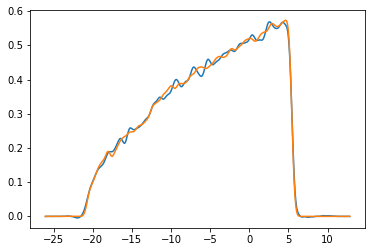

In [319]:
%matplotlib inline
plt.plot(xdos, zeroed_train_predictions[0])
plt.plot(xdos, ldos[train_index][0])

In [96]:
train_rmse = loss.t_get_rmse(zeroed_train_predictions, ldos[train_index], xdos, perc = True)
test_rmse = loss.t_get_rmse(zeroed_test_predictions, ldos[test_index], xdos, perc = True)

print ("Real Space to gaussian: Train_loss: {:.6}, Test_loss:{:.6}".format(train_rmse, test_rmse))

Real Space to gaussian: Train_loss: 10.3285, Test_loss:11.7687


### Evaluate the equivalent shift using normal ldos

In [97]:
##Generate individual xdos, ldos
new_train_ldos = []

sigma = torch.tensor(0.3)
ndos = 778

emin = -24.5537 - 1.5
emax = 11.3464 + 1.5
x_dos = torch.linspace(emin, emax, 778)
for j, i in enumerate(tqdm(train_index)):
    
    l_dos = torch.sum(torch.exp(-0.5*((x_dos + best_state1[j] - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
    new_train_ldos.append(l_dos)

new_train_ldos = torch.vstack(new_train_ldos)
new_train_ldos = ((new_train_ldos.T * normalization[train_index] ).T)* 2

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 831/831 [00:57<00:00, 14.34it/s]


In [98]:
##Generate individual xdos, ldos
new_test_ldos = []

sigma = torch.tensor(0.3)
ndos = 778

emin = -24.5537 - 1.5
emax = 11.3464 + 1.5
x_dos = torch.linspace(emin, emax, 778)
for j, i in enumerate(tqdm(test_index)):
    
    l_dos = torch.sum(torch.exp(-0.5*((x_dos - shifted_test_loss[1][j]- full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
    new_test_ldos.append(l_dos)
    
new_test_ldos = torch.vstack(new_test_ldos)
new_test_ldos = ((new_test_ldos.T * normalization[test_index] ).T)* 2

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:12<00:00, 16.03it/s]


In [ ]:
plt.plot(xdos, orig_test_ldos[0])
plt.plot(xdosm )

In [ ]:
plt.plot(xdos, ldos[train_index[1]], c= 'b')
plt.plot(x_dos, new_train_ldos[1], c= 'g')
plt.plot(xdos, shifted_train_preds[1], c= 'r')

In [ ]:
%matplotlib notebook
plt.plot(xdos, ldos[test_index[0]], c= 'b')
plt.plot(xdos, new_test_ldos[0].detach(), c= 'g')
plt.plot(xdos, shifted_test_preds[0], c= 'r')

In [99]:
# shifted_target = shift_coeffs(new_train_ldos, emin, emax, best_state1) 
# shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,new_train_ldos.shape[1])])   
shifted_reg_target = torch.vstack([new_train_ldos, torch.zeros(n_col,new_train_ldos.shape[1])])

shifted_weights = torch.linalg.lstsq(reg_features.double(), shifted_reg_target, driver = "gelsd").solution

shifted_train_preds = Features.double() @ shifted_weights
shifted_test_preds = t_Features.double() @ shifted_weights

train_rmse = loss.t_get_rmse(shifted_train_preds, new_train_ldos, xdos, perc = True)
test_rmse = loss.t_get_rmse(shifted_test_preds, new_test_ldos, xdos, perc = True)

print ("Using fourier shifts, Train_rmse:{:.6}, Test_rmse {:.6}".format(train_rmse, test_rmse)) 

Using fourier shifts, Train_rmse:12.4497, Test_rmse 13.9672


In [ ]:
plt.plot(xdos, ldos[train_index[0]], c= 'b')
plt.plot(xdos, new_train_ldos[0], c= 'g')

In [ ]:
10.5, 17.4

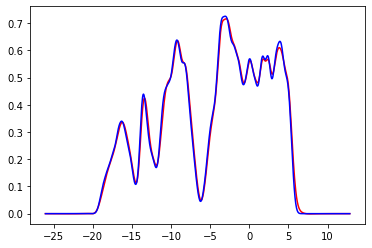

In [32]:
plt.plot(xdos, shifted_test_preds[0], c= 'r')
plt.plot(xdos, new_test_ldos[0].detach(), c= 'b')

In [101]:
# original_target = shift_coeffs(ldos[train_index], emin, emax, best_state1) 
# original_reg_target = torch.vstack([original_target, torch.zeros(n_col,ldos.shape[1])])   


original_reg_target = torch.vstack([ldos[train_index], torch.zeros(n_col,ldos.shape[1])])

original_weights = torch.linalg.lstsq(reg_features.double(), original_reg_target, driver = "gelsd").solution

original_train_preds = Features.double() @ original_weights
original_test_preds = t_Features.double() @ original_weights

train_rmse = loss.t_get_rmse(original_train_preds, ldos[train_index], xdos, perc = True)
test_rmse = loss.t_get_rmse(original_test_preds, ldos[test_index], xdos, perc = True)

print ("No shifts, Train_rmse:{:.6}, Test_rmse {:.6}".format(train_rmse, test_rmse))

No shifts, Train_rmse:10.9057, Test_rmse 12.4247


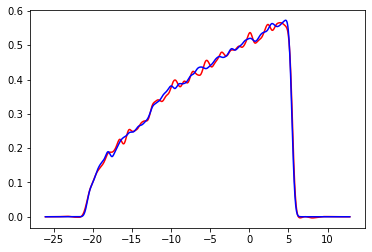

In [248]:
plt.plot(xdos, original_train_preds[0], c= 'r')
plt.plot(xdos, ldos[train_index[0]], c= 'b')

### Evaluate using quartic ldos

In [68]:
def quartic_dos(energies,xdos, sigma):
   
    left_b = energies - (np.sqrt(7) * sigma)

    output = torch.zeros_like(xdos)

    left_bound = torch.searchsorted(xdos, left_b)
    
    xdos_interval = xdos[1]-xdos[0]
    interval = int((2 * (np.sqrt(7) * sigma))/xdos_interval) + 1
    indexes = torch.clamp(left_bound.repeat(interval,1) + torch.arange(0,interval,1).view(-1,1), 0, len(xdos)-1)
                     
    E = torch.clamp((energies.view(1,-1) - xdos[indexes]), min = -1* (np.sqrt(7) * sigma), max = (np.sqrt(7) * sigma))
    values = (E**2 - (7 * (sigma**2))) **2 / ((16/15) * (np.sqrt(7) * sigma)**5)
    output.index_add_(0, indexes.flatten(), values.flatten())

#     output = -1 * output
    
    return output

In [102]:

sorted_full_eigen_energies = [torch.sort(i)[0] for i in full_eigen_energies]

##Generate individual xdos, ldos
with torch.no_grad():
    train_ldos2 = []

    sigma = torch.tensor(0.3)
    ndos = 778 #+ int(30/0.05)


    emin = -24.5537 - 1.5
    emax = 11.3464 + 1.5

    x_dos2 = torch.linspace(emin, emax, 778)

    for j,i in enumerate(tqdm(train_index)):
        #steps = int((rbounds[i].item()- (10 * sigma) - lbounds[i].item() - 1.5)/0.05)    
        l_dos2 = quartic_dos(sorted_full_eigen_energies[i] + best_state1[j], x_dos2, sigma)#torch.sum(torch.exp(-0.5*((x_dos - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
    #     n_xdos2.append(x_dos2)
        train_ldos2.append(l_dos2)

    # n_xdos2 = torch.vstack(n_xdos2)
    train_ldos2 = torch.vstack(train_ldos2)
    train_ldos2 = ((train_ldos2.T * normalization_quartic[train_index] ).T)* 2

#Do cutting here?

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 831/831 [00:02<00:00, 375.96it/s]


In [103]:
sorted_full_eigen_energies = [torch.sort(i)[0] for i in full_eigen_energies]

##Generate individual xdos, ldos
with torch.no_grad():
    test_ldos2 = []

    sigma = torch.tensor(0.3)
    ndos = 778 #+ int(30/0.05)


    emin = -24.5537 - 1.5
    emax = 11.3464 + 1.5

    x_dos2 = torch.linspace(emin, emax, 778)

    for j,i in enumerate(tqdm(test_index)):
        #steps = int((rbounds[i].item()- (10 * sigma) - lbounds[i].item() - 1.5)/0.05)    
        l_dos2 = quartic_dos(sorted_full_eigen_energies[i] - shifted_test_loss[1][j], x_dos2, sigma)#torch.sum(torch.exp(-0.5*((x_dos - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
    #     n_xdos2.append(x_dos2)
        test_ldos2.append(l_dos2)

    # n_xdos2 = torch.vstack(n_xdos2)
    test_ldos2 = torch.vstack(test_ldos2)
    test_ldos2 = ((test_ldos2.T * normalization_quartic[test_index] ).T)* 2

#Do cutting here?

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 387.13it/s]


In [71]:
with torch.no_grad():
    quartic_ldos = []

    sigma = torch.tensor(0.3)
    ndos = 778 #+ int(30/0.05)


    emin = -24.5537 - 1.5
    emax = 11.3464 + 1.5

    x_dos2 = torch.linspace(emin, emax, 778)

    for i in tqdm(range(len(sorted_full_eigen_energies))):
        #steps = int((rbounds[i].item()- (10 * sigma) - lbounds[i].item() - 1.5)/0.05)    
        l_dos2 = quartic_dos(sorted_full_eigen_energies[i], x_dos2, sigma)#torch.sum(torch.exp(-0.5*((x_dos - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
    #     n_xdos2.append(x_dos2)
        quartic_ldos.append(l_dos2)

    # n_xdos2 = torch.vstack(n_xdos2)
    quartic_ldos = torch.vstack(quartic_ldos)
    quartic_ldos = ((quartic_ldos.T * normalization_quartic).T)* 2

#Do cutting here?

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [00:02<00:00, 392.63it/s]


In [104]:
# shifted_target = shift_coeffs(new_train_ldos, emin, emax, best_state1) 
# shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,new_train_ldos.shape[1])])   
shifted_reg_target = torch.vstack([train_ldos2, torch.zeros(n_col,new_train_ldos.shape[1])])

shifted_weights = torch.linalg.lstsq(reg_features.double(), shifted_reg_target, driver = "gelsd").solution

shifted_train_preds = Features.double() @ shifted_weights
shifted_test_preds = t_Features.double() @ shifted_weights

train_rmse = loss.t_get_rmse(shifted_train_preds, train_ldos2, xdos, perc = True)
test_rmse = loss.t_get_rmse(shifted_test_preds, test_ldos2, xdos, perc = True)

print ("Using fourier shifts, Train_rmse:{:.6}, Test_rmse {:.6}".format(train_rmse, test_rmse)) 

Using fourier shifts, Train_rmse:9.71838, Test_rmse 11.1712


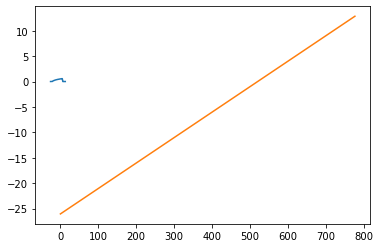

In [73]:
plt.plot(xdos, ldos[train_index[0]])
plt.plot(xdos)

In [105]:
# original_target = shift_coeffs(ldos[train_index], emin, emax, best_state1) 
# original_reg_target = torch.vstack([original_target, torch.zeros(n_col,ldos.shape[1])])   


original_reg_target = torch.vstack([quartic_ldos[train_index], torch.zeros(n_col,ldos.shape[1])])

original_weights = torch.linalg.lstsq(reg_features.double(), original_reg_target, driver = "gelsd").solution

original_train_preds = Features.double() @ original_weights
original_test_preds = t_Features.double() @ original_weights

train_rmse = loss.t_get_rmse(original_train_preds, quartic_ldos[train_index], xdos, perc = True)
test_rmse = loss.t_get_rmse(original_test_preds, quartic_ldos[test_index], xdos, perc = True)

print ("No shifts, Train_rmse:{:.6}, Test_rmse {:.6}".format(train_rmse, test_rmse))

No shifts, Train_rmse:10.436, Test_rmse 11.9341


## For Biased Index

In [24]:
from dostools.loss import loss
#normal dataset

batch_size = 32
sigma = 0.3
n_epochs = 100000
patience = 20

index = biased_train_index
t_index = biased_test_index

Sampler = torch.utils.data.RandomSampler(index, replacement = False)
Batcher = torch.utils.data.BatchSampler(Sampler, batch_size, False)

Features = torch.hstack([feature[index].double(), torch.ones(len(index)).view(-1,1)]).type(dtype = torch.complex128)
t_Features = torch.hstack([feature[t_index].double(), torch.ones(len(t_index)).view(-1,1)]).type(dtype = torch.complex128)
# Features = torch.hstack([Silicon.Features['structure_avedescriptors'][index].double(), torch.ones(len(index)).view(-1,1)])
# t_Features = torch.hstack([Silicon.Features['structure_avedescriptors'][t_index].double(), torch.ones(len(t_index)).view(-1,1)])
alignment = torch.nn.parameter.Parameter(torch.zeros(len(index)))

opt = torch.optim.Adam([alignment], lr = 1e-3, weight_decay = 0)
# opt_LBFGS = torch.optim.LBFGS([alignment], lr = 1e-3, line_search_fn = 'strong_wolfe', tolerance_grad = 1e-15, tolerance_change = 1e-15)#, weight_decay = 0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = 10, threshold = 1e-5, min_lr = 1e-8)

xdos_i = xdos.clone()
# cutoff = torch.max(efermi) + 3
# cutoff_index = torch.searchsorted(xdos, cutoff)

train_ldos = coeffs[index,:].clone()#n_ldos2[index,:cutoff_index].clone()

best_mse = torch.tensor(100)
best_state = alignment.clone()

n_col = Features.shape[1]
regularization = 1

reg = torch.hstack([torch.real(torch.tensor(regularization * rtkMM)), torch.zeros(rtkMM.shape[0]).view(-1,1)])
reg = torch.vstack([reg, torch.zeros(n_col)])


reg_features = torch.vstack([Features, reg])
reg_target = torch.vstack([train_ldos, torch.zeros(n_col,train_ldos.shape[1])])
reference_weights = torch.linalg.lstsq(reg_features, reg_target, driver = "gelsd", rcond = 1e-10).solution
reference_pred = Features @ reference_weights
reference_t_pred = t_Features @ reference_weights



train_loss = torch.mean(abs(reference_pred- train_ldos)**2) 
test_loss = torch.mean(abs(reference_t_pred- coeffs[t_index])**2) 
current_rmse = torch.tensor(100)
pred_loss = torch.tensor(100)
prev_loss = torch.tensor(100)
trigger = 0
print ("Reference training loss: {:.6}".format(train_loss))
print ("Reference test loss : {:.6}".format(test_loss))

pbar = tqdm(range(n_epochs))
for epoch in pbar:
    pbar.set_description(f"Epoch: {epoch}")
    pbar.set_postfix(pred_loss = pred_loss.item(), lowest_mse = best_mse.item(), trigger = trigger)
    for i_batch in Batcher:
        def closure():
            opt.zero_grad()
            reg_features_i = torch.vstack([Features[i_batch], reg])
            shifted_target = shift_coeffs(train_ldos[i_batch], emin, emax, alignment[i_batch])            
            shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])          
            train_weights = torch.linalg.lstsq(reg_features_i, shifted_reg_target, rcond = 1e-10, driver = "gelsd").solution
            shifted_train_preds = Features[i_batch] @ train_weights
            loss_i = torch.mean(abs(shifted_train_preds - shifted_target)**2) 
            loss_i.backward(inputs = alignment)
            return loss_i
        opt.step(closure)
        train_ldos = train_ldos.detach()
        
    with torch.no_grad():
        shifted_target = shift_coeffs(train_ldos, emin, emax, alignment)
        shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])          
        train_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, rcond = 1e-10, driver = "gelsd").solution
        pred_i = Features @ train_weights
        
        
        i_loss = torch.mean(abs(pred_i - shifted_target)**2) 
       
        pred_loss = i_loss
        if i_loss < prev_loss * (1 + 1e-3): 
            trigger = 0
        else:
            trigger +=1 
            if trigger >= patience:
                alignment = torch.nn.parameter.Parameter(best_state)
                opt = torch.optim.Adam([alignment], lr = opt.param_groups[0]['lr'], weight_decay = 0)
                counter = 0

        if i_loss < best_mse:
            best_mse = i_loss
            best_state = alignment.clone()

        prev_loss = i_loss

        scheduler.step(i_loss)
        if Batcher.batch_size > 1024:
            break
            
        if opt.param_groups[0]['lr'] < 1e-3:
            Batcher.batch_size *= 2 
            opt.param_groups[0]['lr'] = 1e-3
            print ("The batch_size is now:", Batcher.batch_size)


            
            


shifted_target = shift_coeffs(train_ldos, emin, emax, best_state)    
shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])   


shifted_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, driver = "gelsd").solution
shifted_preds = Features @ shifted_weights
shifted_t_preds = t_Features @ shifted_weights


shifted_train_loss = torch.mean(abs(shifted_preds - shifted_target)**2)#loss.t_get_rmse(shifted_preds, shifted_target, xdos, perc = True)
# shifted_test_loss = loss.t_get_rmse(shifted_t_preds, shifted_ldos, xdos, perc = True) Need the one with the new loss function

print ("Final training loss: {:.6}".format(shifted_train_loss))


Reference training loss: 0.00153287
Reference test loss : 0.00264829


Epoch: 2:   0%|                                                                                                            | 2/100000 [00:02<33:54:00,  1.22s/it, lowest_mse=0.00153, pred_loss=0.00153, trigger=0]


KeyboardInterrupt: 

In [46]:
biased_best_state = best_state.clone()

In [47]:
torch.save(biased_best_state, "./biased_best_state2.pt")

In [25]:
biased_best_state = torch.load("./biased_best_state2.pt")



### Baseline no shift

In [26]:
emin = -24.553719539983 - 1.5
emax = 11.346414696331 + 1.5
index= biased_train_index
t_index = biased_test_index

Features = torch.hstack([feature[index].double(), torch.ones(len(index)).view(-1,1)]).type(dtype = torch.complex128)
t_Features = torch.hstack([feature[t_index].double(), torch.ones(len(t_index)).view(-1,1)]).type(dtype = torch.complex128)

xdos_i = xdos.clone()

train_ldos = coeffs[index,:].clone()


n_col = Features.shape[1]
regularization = 1

reg = torch.hstack([torch.real(torch.tensor(regularization * rtkMM)), torch.zeros(rtkMM.shape[0]).view(-1,1)])
reg = torch.vstack([reg, torch.zeros(n_col)])


reg_features = torch.vstack([Features, reg])
reg_target = torch.vstack([train_ldos, torch.zeros(n_col,train_ldos.shape[1])])
reference_weights = torch.linalg.lstsq(reg_features, reg_target, driver = "gelsd", rcond = 1e-10).solution
reference_pred = Features @ reference_weights
reference_t_pred = t_Features @ reference_weights



train_loss = torch.mean(abs(reference_pred- train_ldos)**2) 
test_loss = torch.mean(abs(reference_t_pred- coeffs[t_index])**2) 


print ("Fourier Space")
print ("Reference training loss: {:.6}".format(train_loss))
print ("Reference test loss : {:.6}".format(test_loss))

train_rs = evaluate_dos_from_fourier(reference_pred, emin, emax, num_eval=778)
test_rs = evaluate_dos_from_fourier(reference_t_pred , emin, emax, num_eval=778)


train_rmse = loss.t_get_rmse(train_rs, f_ldos[index], xdos, perc = True)
test_rmse = loss.t_get_rmse(test_rs, f_ldos[t_index], xdos, perc = True)

print ("Real Space")
print ("Reference training loss: {:.6}".format(train_rmse))
print ("Reference test loss : {:.6}".format(test_rmse))

print ("Gaussian Space")
train_rmse = loss.t_get_rmse(train_rs, ldos[index], xdos, perc = True)
test_rmse = loss.t_get_rmse(test_rs, ldos[t_index], xdos, perc = True)

print ("Reference training loss: {:.6}".format(train_rmse))
print ("Reference test loss : {:.6}".format(test_rmse))




Fourier Space
Reference training loss: 0.00153287
Reference test loss : 0.00264829
Real Space
Reference training loss: 10.2953
Reference test loss : 16.2029
Gaussian Space
Reference training loss: 10.4205
Reference test loss : 16.2931


In [27]:
shifted_target = shift_coeffs(train_ldos, emin, emax, 1 * biased_best_state)    
shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])   


shifted_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, driver = "gelsd").solution
shifted_preds = Features @ shifted_weights
shifted_t_preds = t_Features @ shifted_weights

shifted_train_loss = torch.mean(abs(shifted_preds - shifted_target)**2)
shifted_test_loss = MSE_shift_fourier(shifted_t_preds, coeffs[t_index], 5)

print ("Fourier Space: Train_loss: {:.6}, Test_loss:{:.6}".format(shifted_train_loss, shifted_test_loss[0]))


Fourier Space: Train_loss: 0.00134436, Test_loss:0.0023673


In [28]:
shifted_target = shift_coeffs(train_ldos, emin, emax, biased_best_state)    
shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,train_ldos.shape[1])])   


shifted_weights = torch.linalg.lstsq(reg_features, shifted_reg_target, driver = "gelsd").solution
shifted_preds = Features @ shifted_weights
shifted_t_preds = t_Features @ shifted_weights

shifted_train_loss = torch.mean(abs(shifted_preds - shifted_target)**2)
biased_shifted_test_loss = MSE_shift_fourier(shifted_t_preds, coeffs[t_index], 5)


zeroed_train_predictions = evaluate_dos_from_fourier(shift_coeffs(shifted_preds, emin, emax, -1 * biased_best_state) , emin, emax, num_eval=778)
zeroed_test_predictions = evaluate_dos_from_fourier(shift_coeffs(shifted_t_preds, emin, emax, 1 * biased_shifted_test_loss[1]) , emin, emax, num_eval=778)



train_rmse = loss.t_get_rmse(zeroed_train_predictions, f_ldos[biased_train_index], xdos, perc = True)
test_rmse = loss.t_get_rmse(zeroed_test_predictions, f_ldos[biased_test_index], xdos, perc = True)

print ("Real Space: Train_loss: {:.6}, Test_loss:{:.6}".format(train_rmse, test_rmse))

Real Space: Train_loss: 9.64147, Test_loss:15.3193


In [29]:
train_rmse = loss.t_get_rmse(zeroed_train_predictions, ldos[biased_train_index], xdos, perc = True)
test_rmse = loss.t_get_rmse(zeroed_test_predictions, ldos[biased_test_index], xdos, perc = True)

print ("Real Space to gaussian: Train_loss: {:.6}, Test_loss:{:.6}".format(train_rmse, test_rmse))

Real Space to gaussian: Train_loss: 9.77523, Test_loss:15.4148


In [30]:
biased_test_shift = biased_shifted_test_loss[1]
torch.save(biased_test_shift, "./biased_test_shift.pt")

### For gaussian dataset

In [52]:
##Generate individual xdos, ldos
new_biased_train_ldos = []

sigma = torch.tensor(0.3)
ndos = 778

emin = -24.5537 - 1.5
emax = 11.3464 + 1.5
x_dos = torch.linspace(emin, emax, 778)
for j, i in enumerate(tqdm(biased_train_index)):
    
    l_dos = torch.sum(torch.exp(-0.5*((x_dos + biased_best_state[j] - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
    new_biased_train_ldos.append(l_dos)

new_biased_train_ldos = torch.vstack(new_biased_train_ldos)
new_biased_train_ldos = ((new_biased_train_ldos.T * normalization[biased_train_index] ).T)* 2

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 831/831 [01:07<00:00, 12.38it/s]


In [53]:
##Generate individual xdos, ldos
new_biased_test_ldos = []

sigma = torch.tensor(0.3)
ndos = 778

emin = -24.5537 - 1.5
emax = 11.3464 + 1.5
x_dos = torch.linspace(emin, emax, 778)
for j, i in enumerate(tqdm(biased_test_index)):
    
    l_dos = torch.sum(torch.exp(-0.5*((x_dos - biased_shifted_test_loss[1][j]- full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
    new_biased_test_ldos.append(l_dos)
    
new_biased_test_ldos = torch.vstack(new_biased_test_ldos)
new_biased_test_ldos = ((new_biased_test_ldos.T * normalization[biased_test_index] ).T)* 2

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:09<00:00, 21.78it/s]


In [54]:
# shifted_target = shift_coeffs(new_train_ldos, emin, emax, best_state1) 
# shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,new_train_ldos.shape[1])])   
shifted_reg_target = torch.vstack([new_biased_train_ldos, torch.zeros(n_col,new_biased_train_ldos.shape[1])])

shifted_weights = torch.linalg.lstsq(reg_features.double(), shifted_reg_target, driver = "gelsd", rcond = 1e-10).solution

shifted_train_preds = Features.double() @ shifted_weights
shifted_test_preds = t_Features.double() @ shifted_weights

train_rmse = loss.t_get_rmse(shifted_train_preds, new_biased_train_ldos, xdos, perc = True)
test_rmse = loss.t_get_rmse(shifted_test_preds, new_biased_test_ldos, xdos, perc = True)

print ("Using fourier shifts, Train_rmse:{:.6}, Test_rmse {:.6}".format(train_rmse, test_rmse)) 

Using fourier shifts, Train_rmse:11.6673, Test_rmse 18.1646


In [55]:
# original_target = shift_coeffs(ldos[train_index], emin, emax, best_state1) 
# original_reg_target = torch.vstack([original_target, torch.zeros(n_col,ldos.shape[1])])   


original_reg_target = torch.vstack([ldos[biased_train_index], torch.zeros(n_col,ldos.shape[1])])

original_weights = torch.linalg.lstsq(reg_features.double(), original_reg_target, driver = "gelsd").solution

original_train_preds = Features.double() @ original_weights
original_test_preds = t_Features.double() @ original_weights

train_rmse = loss.t_get_rmse(original_train_preds, ldos[biased_train_index], xdos, perc = True)
test_rmse = loss.t_get_rmse(original_test_preds, ldos[biased_test_index], xdos, perc = True)

print ("No shifts, Train_rmse:{:.6}, Test_rmse {:.6}".format(train_rmse, test_rmse))

No shifts, Train_rmse:10.3077, Test_rmse 16.2216


### Quartic Dataset

In [56]:
##Generate individual xdos, ldos
with torch.no_grad():
    biased_train_ldos2 = []

    sigma = torch.tensor(0.3)
    ndos = 778 #+ int(30/0.05)


    emin = -24.5537 - 1.5
    emax = 11.3464 + 1.5

    x_dos2 = torch.linspace(emin, emax, 778)

    for j,i in enumerate(tqdm(biased_train_index)):
        #steps = int((rbounds[i].item()- (10 * sigma) - lbounds[i].item() - 1.5)/0.05)    
        l_dos2 = quartic_dos(sorted_full_eigen_energies[i] + biased_best_state[j], x_dos2, sigma)#torch.sum(torch.exp(-0.5*((x_dos - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
    #     n_xdos2.append(x_dos2)
        biased_train_ldos2.append(l_dos2)

    # n_xdos2 = torch.vstack(n_xdos2)
    biased_train_ldos2 = torch.vstack(biased_train_ldos2)
    biased_train_ldos2 = ((biased_train_ldos2.T * normalization_quartic[biased_train_index] ).T)* 2

#Do cutting here?

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 831/831 [00:02<00:00, 324.02it/s]


In [57]:
##Generate individual xdos, ldos
with torch.no_grad():
    biased_test_ldos2 = []

    sigma = torch.tensor(0.3)
    ndos = 778 #+ int(30/0.05)


    emin = -24.5537 - 1.5
    emax = 11.3464 + 1.5

    x_dos2 = torch.linspace(emin, emax, 778)

    for j,i in enumerate(tqdm(biased_test_index)):
        #steps = int((rbounds[i].item()- (10 * sigma) - lbounds[i].item() - 1.5)/0.05)    
        l_dos2 = quartic_dos(sorted_full_eigen_energies[i] - shifted_test_loss[1][j], x_dos2, sigma)#torch.sum(torch.exp(-0.5*((x_dos - full_eigen_energies[i].view(-1,1))/sigma)**2), dim = 0)
    #     n_xdos2.append(x_dos2)
        biased_test_ldos2.append(l_dos2)

    # n_xdos2 = torch.vstack(n_xdos2)
    biased_test_ldos2 = torch.vstack(biased_test_ldos2)
    biased_test_ldos2 = ((biased_test_ldos2.T * normalization_quartic[biased_test_index] ).T)* 2

#Do cutting here?

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 446.12it/s]


In [58]:
# shifted_target = shift_coeffs(new_train_ldos, emin, emax, best_state1) 
# shifted_reg_target = torch.vstack([shifted_target, torch.zeros(n_col,new_train_ldos.shape[1])])   
shifted_reg_target = torch.vstack([biased_train_ldos2, torch.zeros(n_col,biased_train_ldos2.shape[1])])

shifted_weights = torch.linalg.lstsq(reg_features.double(), shifted_reg_target, driver = "gelsd").solution

shifted_train_preds = Features.double() @ shifted_weights
shifted_test_preds = t_Features.double() @ shifted_weights

train_rmse = loss.t_get_rmse(shifted_train_preds, biased_train_ldos2, xdos, perc = True)
test_rmse = loss.t_get_rmse(shifted_test_preds, biased_test_ldos2, xdos, perc = True)

print ("Using fourier shifts, Train_rmse:{:.6}, Test_rmse {:.6}".format(train_rmse, test_rmse)) 

Using fourier shifts, Train_rmse:9.23298, Test_rmse 14.6728


In [59]:
# original_target = shift_coeffs(ldos[train_index], emin, emax, best_state1) 
# original_reg_target = torch.vstack([original_target, torch.zeros(n_col,ldos.shape[1])])   


original_reg_target = torch.vstack([quartic_ldos[biased_train_index], torch.zeros(n_col,ldos.shape[1])])

original_weights = torch.linalg.lstsq(reg_features.double(), original_reg_target, driver = "gelsd").solution

original_train_preds = Features.double() @ original_weights
original_test_preds = t_Features.double() @ original_weights

train_rmse = loss.t_get_rmse(original_train_preds, quartic_ldos[biased_train_index], xdos, perc = True)
test_rmse = loss.t_get_rmse(original_test_preds, quartic_ldos[biased_test_index], xdos, perc = True)

print ("No shifts, Train_rmse:{:.6}, Test_rmse {:.6}".format(train_rmse, test_rmse))

No shifts, Train_rmse:9.85658, Test_rmse 15.5983


## Last